In [1]:
import dabench as dab
from dabench import vector
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
import jax
from timeit import default_timer as timer
import inspect
import pandas as pd

# Read-in Raytune Results

In [2]:
raytune_system_dim_results = pd.read_csv('./test_raytune_sgdopt_werrors_v3.csv')
raytune_system_dim_results['trialnum'] = raytune_system_dim_results.index
raytune_system_dim_results.index = np.arange(raytune_system_dim_results.shape[0])
rows_to_get = raytune_system_dim_results.groupby(['system_dim']).idxmin(numeric_only=True)['rmse']
best_results_system_dim = raytune_system_dim_results.loc[rows_to_get]

In [3]:
raytune_heatmap_results = pd.read_csv('./test_raytune_sgdopt_werrors_heatmap_v2.csv')
raytune_heatmap_results['trialnum'] = raytune_heatmap_results.index
raytune_heatmap_results.index = np.arange(raytune_heatmap_results.shape[0])
rows_to_get = raytune_heatmap_results.groupby(['num_obs','obs_sd']).idxmin(numeric_only=True)['rmse']
best_results_heatmap = raytune_heatmap_results.loc[rows_to_get]

# Define some parameters

In [4]:
system_dim= 36
spinup_size = 14400
valid_size = 5000
transient_size = 1000
test_size = 5000
nr_steps = spinup_size + valid_size + transient_size + test_size
delta_t=0.01
obs_sd = 0.5
sigma_bg = obs_sd/1.5
sigma_obs = obs_sd*1.25
analysis_window = 0.1
analysis_time_in_window = 0.05
obs_location_count = 18
num_epochs = 3
n_outer_loops = 3
num_runs = 100

# Function def: Backprop

In [5]:
def run_backprop_4dvar(system_dim, nr_steps, spinup_size, valid_size, transient_size, test_size, test_run, delta_t, obs_location_count,
              obs_sd, sigma_bg, sigma_obs, analysis_window, analysis_time_in_window,
              random_seed, num_epochs, learning_rate, lr_decay):
    np_rng = np.random.default_rng(random_seed)
    jax.clear_backends()


    ### Nature Run
    nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)


    x0_initial = np_rng.normal(size=system_dim, scale=1)
    nature_run.generate(n_steps=nr_steps, x0 = x0_initial) 
    nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
        spinup_size, valid_size, transient_size + test_size)
    nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

    if not test_run:
        nr_eval = nr_valid
    else:
        nr_eval = nr_test
    ### Observations
    # Now we can define the observer:
    obs_l96 = dab.observer.Observer(
        nr_eval, # Data generator object
        time_indices = np.arange(0, nr_eval.time_dim, 5), # Observation every other timestep
        random_location_count = obs_location_count, # Probability of picking each location in l63.system_dim for random sampling
        error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
        error_sd = obs_sd, # Standard deviation for observation error, Gaussian/Normal distribution
        random_seed=random_seed, # We can specify a random seed. Default is 99
        stationary_observers=True,
        store_as_jax=True
    )

    # Making observations
    obs_vec_l96 = obs_l96.observe()


    # Model
    model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

    class L96Model(dab.model.Model):                                                                       
        """Defines model wrapper for Lorenz96 to test forecasting."""
        def forecast(self, state_vec, n_steps):
            self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
            new_vals = self.model_obj.values 

            new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

            return new_vec

    fc_model = L96Model(model_obj=model_l96)
    
    ### Set up DA matrices
    obs_total_size = int(obs_location_count*3)
    
    H = np.zeros((obs_location_count, system_dim))
    H[np.arange(H.shape[0]), np.tile(obs_vec_l96.location_indices[0], 1)] = 1
    R = (sigma_obs**2)* np.identity(obs_total_size)
    B = (sigma_bg**2)*np.identity(system_dim)

    
    da_time_start = timer()

    
    dc = dab.dacycler.Var4DBackprop(
        system_dim=system_dim,
        delta_t=nr_eval.delta_t,
        H=H,
        B=B,
        R=R,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        lr_decay=lr_decay,
        model_obj=fc_model,
        obs_window_indices=[0,5,10],
        steps_per_window=11,
        loss_growth_limit=1000# 11 instead of 10 because inclusive of 0 and 11
        )

    
    ### Execute
    cur_tstep = 0
    x0_original = nr_eval.values[cur_tstep] + np_rng.normal(size=(system_dim,), scale=1)

    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)
    

    out_statevec = dc.cycle(
        input_state = x0_sv,
        start_time = nr_eval.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=498,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    da_time = timer()-da_time_start

    rmse = np.sqrt(np.mean(np.square(nr_eval.values[:-20] - out_statevec.values)))
    
    
    return out_statevec, rmse, obs_vec_l96, nr_eval, da_time

# Function def: 4DVar

In [6]:
def run_4dvar(system_dim, nr_steps, spinup_size, valid_size, transient_size, test_run, test_size, delta_t, obs_location_count, 
              obs_sd, sigma_bg, sigma_obs, analysis_window, analysis_time_in_window,
              random_seed, n_outer_loops):
    np_rng = np.random.default_rng(random_seed)
    jax.clear_backends()


    ### Nature Run
    nature_run = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)
    x0_initial = np_rng.normal(size=system_dim, scale=1)
    nature_run.generate(n_steps=nr_steps, x0 = x0_initial) #np_rng.normal(size=system_dim))
    nr_spinup, nr_valid, nr_transient_and_test = nature_run.split_train_valid_test(
        spinup_size, valid_size, transient_size + test_size)
    nr_transient, nr_test, _ = nr_transient_and_test.split_train_valid_test(transient_size, test_size, 0)

    if not test_run:
        nr_eval = nr_valid
    else:
        nr_eval = nr_test
    ### Observations
    # Now we can define the observer:
    obs_l96 = dab.observer.Observer(
        nr_eval, # Data generator object
        time_indices = np.arange(0, nr_eval.time_dim, 5), # Observation every other timestep
        random_location_count = obs_location_count, # Probability of picking each location in l63.system_dim for random sampling
        error_bias = 0.0, # Mean for observation error, Gaussian/Normal distribution
        error_sd = obs_sd, # Standard deviation for observation error, Gaussian/Normal distribution
        random_seed=random_seed, # We can specify a random seed. Default is 99
        stationary_observers=True,
        store_as_jax=True
    )

    # Making observations
    obs_vec_l96 = obs_l96.observe()
    # Model
    model_l96 = dab.data.Lorenz96(system_dim=system_dim, delta_t=delta_t, store_as_jax=True, random_seed=random_seed)

    class L96Model(dab.model.Model):                                                                       
        """Defines model wrapper for Lorenz96 to test forecasting."""
        def forecast(self, state_vec,n_steps):
            self.model_obj.generate(x0=state_vec.values, n_steps=n_steps)
            new_vals = self.model_obj.values 

            new_vec = dab.vector.StateVector(values=new_vals, store_as_jax=True)

            return new_vec

        def compute_tlm(self, state_vec, n_steps):
            """For 4DVar. Not used for Backprop4DVar"""
            M = self.model_obj.generate(n_steps=n_steps, x0=state_vec.values, return_tlm=True)
            return M, self.model_obj.values

    fc_model = L96Model(model_obj=model_l96)
    
    ### Set up DA matrices
    H = np.zeros((obs_location_count, system_dim))
    H[np.arange(H.shape[0]), obs_vec_l96.location_indices[0]] = 1
    R = (sigma_obs**2)*np.eye(H.shape[0])
    B = np.identity(system_dim)*(sigma_bg**2)
    Bsqrt = np.sqrt(B)
    
    da_time_start = timer()
    
    ### Define 4dvar
    dc = dab.dacycler.Var4D(
    system_dim=system_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    Bsqrt=Bsqrt,
    n_outer_loops=n_outer_loops,
    model_obj=fc_model,
    obs_window_indices=[0,5, 10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )
    
    ### Execute
    cur_tstep = 0
    x0_original = nr_eval.values[cur_tstep] + np_rng.normal(size=(system_dim,), scale=1)

    x0_sv = dab.vector.StateVector(
        values=x0_original,
        store_as_jax=True)

    out_statevec_4dvar = dc.cycle(
        input_state = x0_sv,
        start_time = nr_eval.times[cur_tstep],
        obs_vector = obs_vec_l96,
        analysis_window=analysis_window,
        timesteps=498,
        obs_error_sd=sigma_obs,
        analysis_time_in_window=analysis_time_in_window)
    
    da_time = timer()-da_time_start
    
    rmse = np.sqrt(np.mean(np.square(nr_eval.values[:-20] - out_statevec_4dvar.values)))
    
    return out_statevec_4dvar, rmse, obs_vec_l96, nr_eval, da_time


# Validation: test some different learning rates and decays and number of epochs

In [7]:
out_dict_list_bp = []
random_seed_list = np.arange(num_runs)
system_dim_list = [6, 20, 36, 72, 144, 256]
for system_dim in system_dim_list:
    obs_location_count = int(system_dim/2)
    best_results_filtered = best_results_system_dim.loc[best_results_system_dim['system_dim']==system_dim]
    learning_rate = best_results_filtered['config/lr'].values[0]
    lr_decay = best_results_filtered['config/lr_decay'].values[0]

    for i in range(num_runs):
        random_seed = system_dim + random_seed_list[i]
        run_dict = dict(
            system_dim=system_dim, 
            nr_steps=nr_steps,
            spinup_size=spinup_size,
            valid_size=valid_size,
            transient_size=transient_size,
            test_size=test_size,
            test_run=False,
            delta_t=delta_t,
            obs_location_count=obs_location_count,
            obs_sd=obs_sd,
            sigma_bg=sigma_bg,
            sigma_obs=sigma_obs,
            analysis_window=analysis_window,
            analysis_time_in_window=analysis_time_in_window,
            random_seed=random_seed,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            lr_decay = lr_decay)
        out_bp, error_bp, obs_vec_l96, nr_eval, da_time = run_backprop_4dvar(**run_dict)
        run_dict['time'] = da_time 
        run_dict['rmse'] = error_bp
        run_dict['run_num'] = i
        print('Run {}, Time = {}'.format(i,run_dict['time']))
        out_dict_list_bp.append(run_dict)
        
bp_df_time =  pd.DataFrame(out_dict_list_bp)
bp_df_time.to_csv('./out/bp_df_time_v30_raytune_best_epochs3_val.py')

[[28.84030062 32.56608445 31.85524578]
 [15.94946624 26.67366624 36.00330791]
 [11.08730382 12.71392028 13.29702371]
 ...
 [ 8.36576015  7.87449842  7.62242307]
 [11.59766694 10.65637912 10.08106263]
 [14.73108176 11.74721411 10.13763357]]
Run 0, Time = 10.763952648994746
[[11.63189469  9.98335     8.40742431]
 [15.29277894 14.40103135 11.63445166]
 [12.50800415 10.5846505   8.79715498]
 ...
 [ 5.00526355  4.69743096  4.0732177 ]
 [21.21910311 19.54631368 16.29235537]
 [ 7.28373319  6.91589218  6.05846201]]
Run 1, Time = 9.50279432500247
[[34.77236495 28.7124133  25.26587354]
 [39.68454403 34.64816692 27.04329253]
 [11.88152732 10.36528188  8.53784564]
 ...
 [ 2.45864911  2.3821883   2.30363441]
 [ 3.90671467  3.71802233  3.57531072]
 [ 8.90197344  7.41485135  6.33161138]]
Run 2, Time = 9.73435420700116
[[39.07856665 30.24246477 27.50126819]
 [17.40389287 15.09901257 13.77866412]
 [ 6.80623838  6.32487875  6.05876956]
 ...
 [ 3.99825986  3.98294404  3.98527232]
 [ 5.68868439  5.2717090

[[1322.16535909 2298.1724024   887.06584373]
 [ 693.52107281 1173.81189148  496.43279765]
 [ 455.53416783  705.73799138  338.64232538]
 ...
 [ 498.29127943  764.39563185  371.9071386 ]
 [ 412.69805649  651.77758808  309.79128337]
 [ 383.15207486  603.05208107  296.29006626]]
Run 3, Time = 12.28965052300191
[[1298.15574953 2251.61798383  883.49597589]
 [ 523.60009538  748.07657695  397.27269405]
 [ 580.07530547  911.51780728  430.09978123]
 ...
 [ 363.05922272  484.53749743  295.06034502]
 [ 361.12100805  498.84069532  289.76850393]
 [ 335.15229177  433.2831645   276.11257275]]
Run 4, Time = 12.338840238007833


In [ ]:
out_dict_list_4dvar = []

random_seed_list = np.arange(num_runs)
system_dim_list = [6, 20, 36, 72, 144, 256]
for system_dim in system_dim_list:
    for i in range(num_runs):
        obs_location_count = int(system_dim/2)
        random_seed = system_dim + random_seed_list[i]
        run_dict = dict(system_dim=system_dim, 
            nr_steps=nr_steps,
            spinup_size=spinup_size,
            valid_size=valid_size,
            transient_size=transient_size,
            test_size=test_size,
            test_run=False,
            delta_t=delta_t,
            obs_location_count=obs_location_count,
            obs_sd=obs_sd,
            sigma_bg=sigma_bg,
            sigma_obs=sigma_obs,
            analysis_window=analysis_window,
            analysis_time_in_window=analysis_time_in_window,
            random_seed=random_seed,
            n_outer_loops = n_outer_loops)
        out_4dvar, error_4dvar, obs_vec_l96, nr_eval, da_time = run_4dvar(**run_dict)
        run_dict['time'] = da_time
        run_dict['rmse'] = error_4dvar
        run_dict['run_num'] = i
        print('Run {}, Time = {}'.format(i,run_dict['time']))
        out_dict_list_4dvar.append(run_dict)
        
var4d_df_time =  pd.DataFrame(out_dict_list_4dvar)
var4d_df_time.to_csv('./out/var4d_df_time_v30_3outer_val.csv')

# Heatmap: num_obs and obs_error (validation set)

In [9]:
out_dict_list_4dvar_obs = []
num_runs = 1
system_dim = 36
random_seed = system_dim
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = np.arange(0.1, 1.05, 0.1)
for obs_location_count in num_obs_list:
    for obs_sd in obs_error_list:
        for i in range(num_runs):
            run_dict = dict(system_dim=system_dim, 
                nr_steps=nr_steps,
                spinup_size=spinup_size,
                valid_size=valid_size,
                transient_size=transient_size,
                test_size=test_size,
                test_run=False,
                delta_t=delta_t,
                obs_location_count=obs_location_count,
                obs_sd=obs_sd,
                sigma_bg=obs_sd/1.5,
                sigma_obs=obs_sd*1.25,
                analysis_window=analysis_window,
                analysis_time_in_window=analysis_time_in_window,
                random_seed=random_seed,
                n_outer_loops = n_outer_loops)
            out_4dvar, error_4dvar, obs_vec_l96, nature_run, da_time = run_4dvar(**run_dict)
            run_dict['time'] = da_time
            run_dict['rmse'] = error_4dvar
            run_dict['run_num'] = i
            print('Run {}, Time = {}'.format(i,run_dict['time']))
            out_dict_list_4dvar_obs.append(run_dict)
            
var4d_df_obs =  pd.DataFrame(out_dict_list_4dvar_obs)
var4d_df_obs.to_csv('./out/var4d_df_obs_v30_3outer_val.csv')

Run 0, Time = 9.925945025002875
Run 0, Time = 9.664735662998282
Run 0, Time = 9.877644127001986
Run 0, Time = 9.621460192000086
Run 0, Time = 9.910640376001538
Run 0, Time = 9.688459072000114
Run 0, Time = 9.902264559001196
Run 0, Time = 9.733204272000876
Run 0, Time = 9.863275809999323
Run 0, Time = 9.867354494002939
Run 0, Time = 9.928523647002294
Run 0, Time = 9.617219270003261
Run 0, Time = 9.937886899002478
Run 0, Time = 9.726528988998325
Run 0, Time = 9.927454669996223
Run 0, Time = 9.58215473099699
Run 0, Time = 9.55080685899884
Run 0, Time = 9.459572469000705
Run 0, Time = 9.668080990995804
Run 0, Time = 9.602126701996895
Run 0, Time = 10.002298772997165
Run 0, Time = 9.835208108001098
Run 0, Time = 10.02631022699643
Run 0, Time = 9.785435276004137
Run 0, Time = 10.046307311000419
Run 0, Time = 9.757671487001062
Run 0, Time = 10.08132654500514
Run 0, Time = 9.726318518994958
Run 0, Time = 10.076996534997306
Run 0, Time = 9.904710743001488
Run 0, Time = 9.76108116099931
Run 0, T

In [10]:
out_dict_list_bp_obs = []
num_runs = 1
num_epochs=3
system_dim = 36
random_seed = system_dim
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = np.arange(0.1, 1.05, 0.1)
for obs_location_count in num_obs_list:
    for obs_sd in obs_error_list:
        best_results_filtered = best_results_heatmap.loc[
            (best_results_heatmap['obs_sd'].round(2)==round(obs_sd, 2)) & 
            (best_results_heatmap['num_obs']==obs_location_count)]
        learning_rate = best_results_filtered['config/lr'].values[0]
        lr_decay = best_results_filtered['config/lr_decay'].values[0]
        for i in range(num_runs):
            run_dict = dict(system_dim=system_dim, 
                nr_steps=nr_steps,
                spinup_size=spinup_size,
                valid_size=valid_size,
                transient_size=transient_size,
                test_size=test_size,
                test_run=False,
                delta_t=delta_t,
                obs_location_count=obs_location_count,
                obs_sd=obs_sd,
                sigma_bg=obs_sd/1.5,
                sigma_obs=obs_sd*1.25,
                analysis_window=analysis_window,
                analysis_time_in_window=analysis_time_in_window,
                random_seed=random_seed,
                num_epochs=num_epochs,
                learning_rate=learning_rate,
                lr_decay=lr_decay)
            out_bp, error_bp, obs_vec_l96, nature_run, da_time = run_backprop_4dvar(**run_dict)
            run_dict['time'] = da_time
            run_dict['rmse'] = error_bp
            run_dict['run_num'] = i
            print('Run {}, Time = {}'.format(i,run_dict['time']))
            print(obs_location_count, obs_sd, error_bp)
            out_dict_list_bp_obs.append(run_dict)
            
bp_df_obs =  pd.DataFrame(out_dict_list_bp_obs)
bp_df_obs.to_csv('./out/bp_df_obs_v30_raytune_best_epochs3_val.csv')

[[1356.67242259  711.05342742  708.19585745]
 [ 785.63155183  403.71283943  401.71740353]
 [ 262.93196635  151.12868868  149.98278132]
 ...
 [7678.15714251 4458.89285565 4423.45610824]
 [2838.9056317  1907.35918872 1897.65692727]
 [7412.04167454 4592.07920505 4557.10647406]]
Run 0, Time = 8.467941028000496
6 0.1 3.805668314793605
[[338.78359026 405.77391454 260.35091113]
 [ 51.44337348  53.40813342  40.20798078]
 [ 32.8659657   34.52290815  26.46433277]
 ...
 [712.64555649 699.23951509 521.88270304]
 [ 71.0408874   74.21147264  54.78860069]
 [191.827013   184.4674417  149.38953695]]
Run 0, Time = 8.574903376000293
6 0.2 3.417806274030414
[[151.952402   123.81644112  83.67829988]
 [ 60.02825013  53.93777698  34.05899822]
 [ 32.85216164  30.07008966  21.00390789]
 ...
 [380.39349551 281.65788034 249.51141694]
 [601.09503541 437.02132366 378.90566304]
 [547.24445745 383.16614975 330.4984627 ]]
Run 0, Time = 8.245315271997242
6 0.30000000000000004 3.727769640475247
[[ 87.12401209 270.15174

[[88.64276719 68.01681022 63.33052319]
 [55.57667746 42.57718514 41.6840711 ]
 [58.71073063 47.40511929 46.5288551 ]
 ...
 [84.43209926 61.17876353 60.04445684]
 [58.39315184 43.85991896 42.97264498]
 [61.07731225 48.19832703 47.70691433]]
Run 0, Time = 8.109020354000677
18 0.7000000000000001 0.7175324461588743
[[74.51302694 59.21824412 48.54512603]
 [60.07797572 46.08546072 41.78053326]
 [60.07599175 48.77415812 44.95081686]
 ...
 [90.34542332 66.72670446 60.76197855]
 [73.95286099 55.59257868 48.89395846]
 [70.4338426  54.39961357 51.91718334]]
Run 0, Time = 8.813767193998501
18 0.8 0.8695762437644008
[[64.77970631 44.13986751 42.25383765]
 [55.06491926 39.32921583 38.79685079]
 [54.56193633 42.31217653 41.85256488]
 ...
 [98.18589878 65.43923384 64.85287906]
 [81.88839876 54.20211743 52.84055332]
 [72.14204456 53.70542643 53.46282589]]
Run 0, Time = 8.128766884998186
18 0.9 0.9338915680593501
[[ 57.78463055  39.19178181  38.93608212]
 [ 49.77820941  36.38508327  36.28866688]
 [ 51.0

[[705.98026235 426.37946992 401.26378832]
 [370.26620171 233.99077387 221.17526977]
 [209.17808587 134.61398369 128.73192975]
 ...
 [ 63.17492439  58.47647958  57.90185286]
 [ 73.92788738  62.13087226  60.6862182 ]
 [ 68.71329346  57.84959389  56.52328806]]
Run 0, Time = 8.293107876997965
36 0.30000000000000004 0.10243545944012707
[[412.62172541 261.21560798 246.16990714]
 [248.97117968 166.92553378 158.42630577]
 [155.50709591 107.66571681 103.30088855]
 ...
 [ 62.98303045  58.55880489  57.97937901]
 [ 73.74810558  62.47230823  61.00342542]
 [ 69.08055738  58.53292649  57.15866998]]
Run 0, Time = 8.24425208500179
36 0.4 0.1316174120591924
[[278.79320789 170.89570063 166.87510975]
 [169.55648703 115.06328139 112.84445418]
 [111.59416668  80.19091495  79.10301641]
 ...
 [ 63.19587808  58.05534431  57.77084808]
 [ 74.06091097  61.2342105   60.50529578]
 [ 68.58304115  56.83004894  56.1796026 ]]
Run 0, Time = 8.277091916002973
36 0.5 0.1633626481974494
[[207.15194815 125.79796795 125.1819

# Repeating everything on the test set    

### Varying system size, BP

In [7]:
out_dict_list_bp = []
random_seed_list = np.arange(num_runs)+100
system_dim_list = [6, 20, 36, 72, 144, 256]
for system_dim in system_dim_list:
    obs_location_count = int(system_dim/2)
    best_results_filtered = best_results_system_dim.loc[best_results_system_dim['system_dim']==system_dim]
    learning_rate = best_results_filtered['config/lr'].values[0]
    lr_decay = best_results_filtered['config/lr_decay'].values[0]

    for i in range(num_runs):
        random_seed = system_dim + random_seed_list[i]
        run_dict = dict(
            system_dim=system_dim, 
            nr_steps=nr_steps,
            spinup_size=spinup_size,
            valid_size=valid_size,
            transient_size=transient_size,
            test_size=test_size,
            test_run=True,
            delta_t=delta_t,
            obs_location_count=obs_location_count,
            obs_sd=obs_sd,
            sigma_bg=sigma_bg,
            sigma_obs=sigma_obs,
            analysis_window=analysis_window,
            analysis_time_in_window=analysis_time_in_window,
            random_seed=random_seed,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            lr_decay = lr_decay)
        out_bp, error_bp, obs_vec_l96, nr_eval, da_time = run_backprop_4dvar(**run_dict)
        run_dict['time'] = da_time 
        run_dict['rmse'] = error_bp
        run_dict['run_num'] = i
        print('Run {}, Time = {}'.format(i,run_dict['time']))
        out_dict_list_bp.append(run_dict)
        
bp_df_time =  pd.DataFrame(out_dict_list_bp)
bp_df_time.to_csv('./out/bp_df_time_v30_raytune_best_epochs3_test.csv')

[[70.17172945 81.72254525 76.60414129]
 [13.86599442 12.65238933 10.49396639]
 [14.11787687 19.83222044 22.26235276]
 ...
 [ 4.1447735   4.15039305  3.84252481]
 [ 6.3257646   6.2293185   5.61169633]
 [ 5.4739472   4.91095287  4.38957737]]
Run 0, Time = 12.047618335000152
[[34.59828622 33.67664515 30.15426805]
 [29.11697245 25.74097324 21.98931763]
 [24.89088789 35.39674433 41.9099227 ]
 ...
 [ 6.91705203  5.93860408  5.51770331]
 [10.20914322  8.867923    8.42249999]
 [ 8.38316096  8.05566059  7.91094589]]
Run 1, Time = 8.687473967998812
[[89.52416773 73.65514604 61.25515994]
 [81.75712367 88.1710341  76.34303151]
 [20.55890444 18.78696518 18.22434236]
 ...
 [12.89366239 11.87117146 11.28567472]
 [ 5.10052499  5.14348626  5.06857217]
 [ 2.53948249  2.40920722  2.24955042]]
Run 2, Time = 7.95844169600241
[[ 4.34378182  3.81828071  3.51723373]
 [ 4.45910553  3.80449417  3.28258897]
 [ 5.41755547  4.88520884  4.17112741]
 ...
 [ 4.19008707  4.1844448   4.20894373]
 [ 2.51458416  2.936847

[[27.94604113 25.15241976 23.29669925]
 [22.45034391 19.21400495 16.66930526]
 [ 4.90637084  4.49254412  3.89481051]
 ...
 [ 4.3704289   3.99961719  3.80435854]
 [ 5.6425906   5.50152612  5.45196138]
 [ 7.6786183   6.77234226  6.00985509]]
Run 31, Time = 7.930440440999519
[[27.79586864 21.94325174 19.43795443]
 [ 6.56892803  6.63787552  6.29191875]
 [ 3.86829779  3.93989123  3.67969655]
 ...
 [ 3.69216281  3.70654223  3.39670372]
 [ 2.44039933  2.1859644   1.96874308]
 [12.77304806 13.67235402 12.64103608]]
Run 32, Time = 8.042044159999932
[[84.692068   84.97553209 70.0423665 ]
 [ 3.85292939  3.31294788  2.96773978]
 [ 1.75910161  1.85059026  1.81562043]
 ...
 [13.31460379 16.52520928 17.32927463]
 [ 8.34063049  7.69687834  6.82554347]
 [ 2.26060743  2.10718727  1.9535989 ]]
Run 33, Time = 8.782421617001091
[[94.89952286 87.88238607 72.71426512]
 [16.31321926 16.00725756 14.4581987 ]
 [ 6.03329341  4.78537479  4.48819355]
 ...
 [ 8.0506354   7.72456775  7.58711491]
 [14.79376383 14.180

[[38.47772279 33.94306164 27.61383124]
 [ 8.83501871  7.73449519  7.31613334]
 [17.95126121 15.36904734 13.74856056]
 ...
 [ 4.00575303  3.83922669  3.57056743]
 [14.77874192 12.98010894 12.1511719 ]
 [14.46769122 13.29207815 12.96707326]]
Run 62, Time = 8.02831563500149
[[ 8.63555361  7.41420591  6.84522754]
 [25.40303408 25.9782199  21.39818498]
 [18.07953614 20.24768996 18.89295873]
 ...
 [ 2.28120161  2.16474451  2.12381896]
 [ 5.2615801   4.6118154   4.14873105]
 [ 5.97395982  5.88691624  5.69329178]]
Run 63, Time = 8.157116406000569
[[25.22458185 21.76079283 18.6874494 ]
 [20.85745587 20.38887456 16.69901515]
 [23.04667204 24.00438707 20.63236083]
 ...
 [10.24191358 11.4316161  11.7030913 ]
 [17.855869   20.48610574 20.66718932]
 [ 2.05075549  2.01701723  1.97701844]]
Run 64, Time = 7.931292862998816
[[26.75484115 27.05147289 24.37530743]
 [ 8.55055994 12.18040714 15.10122682]
 [ 2.34337978  2.23612024  2.19313119]
 ...
 [11.44825684 10.56921746  9.1977289 ]
 [ 4.45128327  4.1299

[[22.78909806 22.4841944  20.11704097]
 [10.81349471 10.04727641  9.76836613]
 [13.79532129 12.90850831 11.93483289]
 ...
 [ 3.17067855  3.44972484  3.70261445]
 [ 7.15633589  7.09216662  7.02218148]
 [ 4.97733266  4.24158644  3.81665487]]
Run 93, Time = 7.92303060300037
[[28.4325798  23.89537868 20.0638693 ]
 [15.82987688 14.67906504 12.92658657]
 [ 6.92866086  7.08210377  6.52982204]
 ...
 [ 6.70708274  5.91302607  5.63688674]
 [ 7.75613133  7.14182881  6.40139789]
 [ 6.11036848  5.73572429  5.65913965]]
Run 94, Time = 7.93035337100082
[[ 9.49663732  8.97440236  8.63925256]
 [ 5.90032537  5.2790248   4.77515972]
 [23.41980183 21.91102375 18.7791506 ]
 ...
 [ 7.83505131  9.24902664  8.51037021]
 [ 3.28115994  2.71900712  2.33495637]
 [12.72054894 13.41447718 13.41680062]]
Run 95, Time = 7.946528701002535
[[34.44433302 27.62214349 22.55172587]
 [14.70346045 11.31750871  9.57229234]
 [ 8.82871178  7.69287295  6.60398555]
 ...
 [ 5.76217372  5.20533742  4.69739288]
 [ 8.39921033  7.91803

[[100.90455243 255.73131964  63.38679742]
 [ 51.4987312  109.49847998  39.71836884]
 [ 58.74557914  91.38892377  47.08134724]
 ...
 [ 28.04820595  41.69484342  23.00184066]
 [ 26.12508308  30.95097682  23.68976755]
 [ 33.40291961  53.39890925  26.04170936]]
Run 22, Time = 8.311820971000998
[[ 88.13995203 141.96213784  64.62384187]
 [ 45.41530842  67.43260748  36.21641148]
 [112.29740613 244.18380423  72.49168653]
 ...
 [ 27.7703603   66.6041092   22.73293839]
 [ 16.57256677  35.59663087  13.05889318]
 [ 28.16245721  62.79291745  20.87980695]]
Run 23, Time = 8.291034315003344
[[ 69.56537888 139.03419604  47.0325228 ]
 [ 46.11788125  98.28801081  32.89879229]
 [ 78.13886094 171.38446357  53.33668524]
 ...
 [ 24.28253574  36.73792174  21.39876243]
 [ 12.83982242  21.91269063  10.04642321]
 [ 16.31456306  25.00361812  13.08199207]]
Run 24, Time = 8.272363380998286
[[ 87.91058377 179.14019683  63.96483902]
 [ 80.88627051 235.23491333  61.31643823]
 [157.64846591 455.15939454 104.40734036]
 

[[ 46.488406    87.59798996  32.36973008]
 [ 29.1641579   62.10023548  21.29759056]
 [ 67.54765301 126.01202782  48.32200972]
 ...
 [ 20.3183212   33.30516519  16.80778327]
 [ 19.62756834  28.80839472  16.08540571]
 [ 38.74890544  50.26785637  33.74562152]]
Run 51, Time = 8.319184988002235
[[ 80.93004827 149.69858247  56.54721888]
 [ 39.13469967  77.5925824   27.66740585]
 [ 47.40990636 133.57517053  29.82203208]
 ...
 [ 29.21897306  50.27682598  21.18562491]
 [ 26.56932433  30.97486821  24.37236781]
 [ 29.2967812   54.01060452  24.04107271]]
Run 52, Time = 8.310630624000623
[[ 87.34501539 148.31120626  61.5360927 ]
 [ 98.86142834 174.53668091  69.53050239]
 [ 52.14328481  82.07085352  39.67364325]
 ...
 [ 24.60632788  78.99466718  20.78694255]
 [ 15.66354232  20.72973686  14.22354175]
 [ 13.33457592  18.21446168  11.74169987]]
Run 53, Time = 8.329132375998597
[[107.51722871 266.40397723  71.18226464]
 [ 76.78358684 122.44170841  56.73820254]
 [ 86.52891369 208.25235148  61.10632268]
 

[[149.23118745 380.66274238  91.91117181]
 [ 77.18689943 155.42700003  53.85238451]
 [ 38.94128236  66.47185428  29.13306008]
 ...
 [ 20.7120237   30.15745785  17.32323526]
 [ 24.21021672  29.83315816  22.12055945]
 [ 28.58810786  35.08598858  25.75443047]]
Run 80, Time = 8.291491197000141
[[133.87261407 675.86717065  86.58623323]
 [ 86.251422   170.78234452  62.10315641]
 [ 62.99851939 139.59560652  42.13918566]
 ...
 [ 30.23240603  49.36221225  26.63503005]
 [ 33.98121556  57.36184508  28.26360014]
 [ 19.13704314  21.73005194  18.13157675]]
Run 81, Time = 8.329557255001419
[[122.92785525 249.31563635  84.56598594]
 [ 73.04062597 171.85326425  46.82403024]
 [ 89.03442933 171.40845283  61.3508522 ]
 ...
 [ 33.1592351  129.17792763  25.11641681]
 [ 31.96006033  97.34557479  23.28667742]
 [ 22.84023767  44.05923688  17.26374517]]
Run 82, Time = 8.353226112001721
[[135.17204272 270.49890151  89.84033175]
 [ 43.02516853  76.69026102  31.76046056]
 [ 32.4571654   56.74844266  23.34103612]
 

[[180.89986657 222.78269969 132.1907292 ]
 [ 94.55139207 119.38166496  69.46142534]
 [ 53.76063925  63.22037166  43.23172312]
 ...
 [ 55.70704755  62.75614607  47.04728514]
 [ 41.60178594  47.84063571  34.26131444]
 [ 67.74441643  91.69107646  50.38806285]]
Run 9, Time = 8.27529211500223
[[148.2297751  171.54374164 107.75925329]
 [ 52.35078043  78.0556999   38.21874544]
 [ 50.91432885  78.20169398  38.93273341]
 ...
 [ 45.39300871  60.87980509  33.90260981]
 [ 28.5442406   31.56526773  24.11702767]
 [ 35.14268982  38.20143997  30.54878505]]
Run 10, Time = 8.305337157002214
[[170.6485633  255.1628897  122.77349027]
 [ 90.28250224 151.96536174  65.0225147 ]
 [ 96.97573162 149.88497406  71.48980622]
 ...
 [ 38.335729    43.23158937  32.93228868]
 [ 55.99429924  59.96617401  48.23267799]
 [ 46.79991744  48.73542903  39.07265108]]
Run 11, Time = 8.333079148000252
[[172.30643315 196.50933966 124.42601174]
 [ 60.37419565  63.39268313  51.07687685]
 [ 61.08587391  77.04351507  47.35660765]
 ..

[[155.76417681 296.35848204 105.5584976 ]
 [ 88.03010359 102.63148858  68.43207478]
 [107.91246602 154.80068854  81.09097411]
 ...
 [ 45.20760169  61.63129553  36.87177186]
 [ 34.90662539  39.1545088   30.31942405]
 [ 51.12412439  59.34950972  41.17194099]]
Run 38, Time = 8.247989699000755
[[217.64640914 282.96518873 151.95482792]
 [ 63.20146819  71.40139094  51.73454935]
 [ 65.83687909  77.33997603  53.36473647]
 ...
 [ 42.47939283  53.16926482  37.48914601]
 [ 33.95552668  40.47191044  28.19779254]
 [ 46.03549345  55.31637061  38.62145477]]
Run 39, Time = 8.234287816998403
[[183.06113754 244.46681932 131.92510988]
 [ 65.80423713  77.18110051  53.8911821 ]
 [ 57.36427319  69.87741908  45.48375068]
 ...
 [ 53.2878611   65.61420335  43.0585089 ]
 [ 69.87581563  81.02254033  56.00782209]
 [ 75.24884163  93.42991452  57.11394675]]
Run 40, Time = 8.311003232996882
[[167.26834568 305.41904024 107.74344699]
 [ 63.5610957   66.72735215  51.43982418]
 [ 39.86267829  50.22233054  31.03070317]
 

[[158.06326601 217.0416065  113.0320311 ]
 [ 94.76418982 124.99605452  71.17615239]
 [ 43.17946069  55.37445891  33.61563869]
 ...
 [ 33.31848691  35.76908792  28.70764021]
 [ 40.65722492  43.80173046  34.28504937]
 [ 41.37397569  42.86754322  36.22466156]]
Run 67, Time = 8.238867351999943
[[209.66533553 274.23408245 153.70615277]
 [ 88.43305962 111.0564816   65.30744183]
 [ 57.37483062  68.84568185  44.42168683]
 ...
 [ 51.33958312  63.68929128  43.3799658 ]
 [ 64.71218775  83.62219112  51.25218229]
 [ 65.68287878  91.91455371  51.17477776]]
Run 68, Time = 8.415904236000642
[[286.41563661 428.1017719  195.83841879]
 [ 52.83011118  72.94454266  39.02180309]
 [ 40.06089462  48.66762426  33.3099098 ]
 ...
 [ 55.84205228  74.90133271  44.28772218]
 [ 38.33394722  40.5291277   35.43706464]
 [ 50.89095611  70.75342485  42.76370706]]
Run 69, Time = 8.233624974000122
[[240.93177261 324.84124593 165.36992182]
 [ 63.96114602  76.76071485  49.97017793]
 [ 86.38536941  98.31890976  67.32950368]
 

[[160.28826254 186.85166928 116.65067569]
 [ 57.43543283  67.96626809  46.12918834]
 [ 54.24584929  68.77561301  42.56699924]
 ...
 [ 45.19397734  55.09541401  36.85761333]
 [ 60.59082287  87.0391116   45.34855381]
 [ 33.59473371  40.69005793  28.20093424]]
Run 96, Time = 8.265240952001477
[[217.40180941 480.16466264 137.54330113]
 [100.73401311 154.82920735  74.39907229]
 [ 52.30841679  55.23151111  45.36673951]
 ...
 [ 45.60464831  54.49384486  37.72920261]
 [ 40.16677299  51.60628609  34.03477508]
 [ 44.9704196   54.22238611  36.49465685]]
Run 97, Time = 8.269711762997758
[[193.77440327 224.95128749 139.70759694]
 [ 86.64991063  88.39165307  69.61690227]
 [ 68.25137048  83.6196559   56.49928289]
 ...
 [ 38.82690727  42.69965805  34.03802032]
 [ 57.39381675  71.23159213  45.22636672]
 [ 38.5691082   42.65251909  31.71673538]]
Run 98, Time = 8.274005381001189
[[131.24920418 145.59288707  97.0838473 ]
 [ 66.38382919  79.90709431  51.50670555]
 [ 49.9665486   61.30489208  38.41048692]
 

[[ 344.98005847 1298.28210306  257.61733579]
 [ 140.84797111  406.97194693  114.27559602]
 [ 137.68321729  361.15907904  112.5595386 ]
 ...
 [ 112.12356112  293.43390772   91.79771048]
 [  93.7731004   195.00788607   81.82118421]
 [ 107.68394305  191.84842904   97.1471025 ]]
Run 24, Time = 8.644593122000515
[[ 347.24416462 1283.39986969  256.11267547]
 [ 128.40985798  499.0649541    95.39511015]
 [ 131.88037943  634.11762061   96.36570915]
 ...
 [  88.58477028  265.44882136   69.4882354 ]
 [  63.79740918  108.78411586   57.76131631]
 [  80.7196508   171.39500931   70.39023791]]
Run 25, Time = 8.579832079998596
[[ 431.96792716 1488.56849571  321.10912881]
 [ 144.66716049  382.53475254  118.22494309]
 [ 165.96038897  542.87949732  129.75018901]
 ...
 [  88.2762814   285.32830622   73.09220978]
 [  88.87046406  351.27300085   76.8645778 ]
 [ 107.14047296  312.79253963   89.39336064]]
Run 26, Time = 8.565783182002633
[[ 356.02185052 1480.59175417  249.45474687]
 [ 158.72469936  464.0676238

[[ 437.69111386 1747.24763582  313.63256391]
 [ 157.31126126  607.30176261  114.85899958]
 [ 112.16151427  340.15442716   90.38377919]
 ...
 [  78.02494768  191.89870581   65.7415616 ]
 [  84.14217034  219.10038639   73.07661184]
 [  83.2863249   198.10306247   71.26923473]]
Run 51, Time = 8.580018085001939
[[ 351.96410826 1205.10938183  284.95033088]
 [ 132.84045016  714.01938582  131.73867083]
 [ 194.65831637 1927.85005505  155.66334596]
 ...
 [ 136.28061687  453.15124227  110.78327231]
 [  88.36678805  268.82169823   71.83139184]
 [ 108.94123301  432.07552756   82.041665  ]]
Run 52, Time = 8.579544259999238
[[ 370.2523337  1439.93965184  270.78530413]
 [ 151.39781108  478.55676011  120.91132007]
 [ 125.80534494  478.99021487  114.91453563]
 ...
 [ 149.30819018  812.34959816   98.25188719]
 [ 132.50391668  712.7451199    89.49188558]
 [  87.76034287  209.15867475   73.83906052]]
Run 53, Time = 8.566111911000917
[[ 285.96862768 1077.28377741  213.28868458]
 [ 135.19529329  346.7098277

[[ 396.50643591 1312.91674852  295.66841053]
 [ 119.01597013  296.4372326    99.24712389]
 [ 116.04053417  286.87291223   97.01067977]
 ...
 [ 223.81191903  684.41734656  175.10265211]
 [ 159.97035334  400.9425121   131.8143205 ]
 [ 158.84420758  446.7501858   127.92466742]]
Run 78, Time = 8.698691257999599
[[300.5406837  818.75007991 239.55104493]
 [109.33063977 302.75840767  89.48575619]
 [ 84.08457004 210.53764878  70.210899  ]
 ...
 [ 91.10415847 217.3027207   77.00392523]
 [ 94.33464139 223.33582308  80.35476486]
 [ 83.61608992 256.16448802  67.36470596]]
Run 79, Time = 8.59014665399809
[[ 551.17073796 2275.27043548  394.65703674]
 [ 111.66842297  304.82281654   90.40482603]
 [ 169.6982621   615.68239159  126.46127503]
 ...
 [  94.42313857  278.65783252   79.08968711]
 [  90.62770015  284.27178042   71.62358125]
 [  83.88150678  214.9231443    69.81557038]]
Run 80, Time = 8.583530616000644
[[ 446.0771189  2078.43627231  324.35199601]
 [ 216.86257834 1465.98069332  139.10201454]
 [

[[ 648.7739215  2532.15746375  850.72200203]
 [ 312.47326282 1190.02757552  405.8427151 ]
 [ 207.72954659  534.67448848  242.65602281]
 ...
 [ 179.24160454  453.01913632  208.67273399]
 [ 187.87369497  499.04933051  218.11400615]
 [ 232.00891353  589.60571619  269.39158115]]
Run 5, Time = 9.14648645700072
[[ 870.72964061 3157.50942946 1118.17605108]
 [ 294.17565868  866.37567616  361.01362037]
 [ 223.91633648  691.40170422  272.88389916]
 ...
 [ 172.64891163  501.30446678  204.47051017]
 [ 181.67044319  519.20346019  217.14338135]
 [ 197.60459699  780.94506503  245.03830769]]
Run 6, Time = 9.128528386998369
[[ 745.6665126  3359.06714791  980.97448877]
 [ 388.52281898 1901.450056    509.40174344]
 [ 299.96486606  803.90318812  348.93780916]
 ...
 [ 212.62984781  755.70172012  248.58899868]
 [ 225.75302001  806.44633586  274.92989327]
 [ 163.69776058  504.299547    200.26662663]]
Run 7, Time = 9.126098883996747
[[ 635.18298152 1971.38580694  804.2346956 ]
 [ 213.33440185  624.15688795  2

[[ 676.26111029 2383.14802645  891.71922434]
 [ 288.83404261  970.12868538  359.9826822 ]
 [ 239.9571485   808.42078289  289.37320005]
 ...
 [ 210.30331723  519.96687957  244.9304081 ]
 [ 143.78331057  331.45349853  165.1129572 ]
 [ 201.62575823  675.65297739  243.85418046]]
Run 32, Time = 9.15111754699683
[[ 774.24273281 2952.80303649 1001.06200712]
 [ 268.9492469   723.34233916  320.77796852]
 [ 201.58551352  674.75076181  237.42423293]
 ...
 [ 278.96594521 1188.89864611  354.90114289]
 [ 235.5209639   981.83290766  300.06968504]
 [ 197.85347924  585.05213702  240.6843626 ]]
Run 33, Time = 9.105968465999467
[[ 921.62086633 4221.5718207  1319.42273329]
 [ 331.43459332 1338.66780577  425.79128624]
 [ 190.77924881  550.45406563  232.13497542]
 ...
 [ 145.18256656  384.88274143  170.11938133]
 [ 152.96310346  444.99462719  180.6902023 ]
 [ 197.9608277   445.17416338  222.91230849]]
Run 34, Time = 9.133139187997585
[[ 779.47815499 2770.52984419 1004.17572058]
 [ 238.82805283  584.12237219

[[ 645.31568364 2566.09112877  832.75720387]
 [ 286.44680282 1188.2219421   350.29319021]
 [ 234.62543712  755.06924652  284.21063269]
 ...
 [ 184.96807581  544.65119751  223.66047976]
 [ 182.10694872  493.56659199  214.2094485 ]
 [ 249.61302261  936.21575455  313.07745732]]
Run 59, Time = 9.147538336001162
[[ 699.70205852 2642.8810132   910.51128475]
 [ 248.51773781  731.8021641   298.90595699]
 [ 266.7952948   844.99749351  324.95050789]
 ...
 [ 216.77966661  582.2715689   255.9387012 ]
 [ 280.53248658  791.92916696  335.54670249]
 [ 192.21645422  515.27913082  224.87626945]]
Run 60, Time = 9.130105182000989
[[ 613.21415452 2132.71412643  782.37916066]
 [ 267.61661375 1170.30801018  356.17599782]
 [ 316.10224316 1039.11219138  381.02251095]
 ...
 [ 194.49212682  455.62573867  225.24086555]
 [ 179.72343228  510.16262409  209.08104833]
 [ 145.28663007  445.87058294  173.8965328 ]]
Run 61, Time = 9.232242284000677
[[ 571.79581368 2514.24316145  765.67797325]
 [ 275.88461072 1397.4686218

[[ 819.96733192 3519.51771736 1081.15029487]
 [ 286.51600296 1205.81012513  368.25072993]
 [ 247.05042989 1018.3374152   303.46056035]
 ...
 [ 233.9168278   590.99321153  273.6295812 ]
 [ 251.17812199  777.60100489  302.20239208]
 [ 247.90313829  955.8936573   319.27804162]]
Run 86, Time = 9.10664759700012
[[ 747.3313289  2893.79236137 1035.66618039]
 [ 229.14496874  729.9736345   283.01611233]
 [ 184.92197639  481.81469503  217.85191619]
 ...
 [ 188.28077606  521.53191574  226.34936476]
 [ 190.09069489  514.00909538  222.49033613]
 [ 218.83249085  595.93517752  262.77094963]]
Run 87, Time = 9.152194782000151
[[ 675.87276559 2361.34299417  858.52524362]
 [ 282.27113209  882.26549824  345.62979876]
 [ 239.45179861  687.30127093  284.75400896]
 ...
 [ 163.16991575  425.52216999  189.04808892]
 [ 227.79116254  669.20969104  263.29977086]
 [ 208.89440898  778.39882474  254.90045103]]
Run 88, Time = 9.073432905999653
[[ 720.47106077 2947.92671693  962.49807479]
 [ 245.69361595  856.98072275

[[1318.63837595 2057.89166452  920.75020159]
 [ 542.56869628  867.63976016  410.17179261]
 [ 496.61388213  868.49358594  366.73590818]
 ...
 [ 402.34161916  601.25168105  314.19552042]
 [ 390.38675629  546.30775425  308.81075158]
 [ 311.02354163  413.84973702  258.60558595]]
Run 13, Time = 10.790435277001961
[[1177.11720696 1909.36641738  806.08484497]
 [ 504.1377373   754.73561198  376.24987337]
 [ 549.36073948  825.53852562  415.55378512]
 ...
 [ 439.40661898  549.68786555  355.85479436]
 [ 560.8878901   903.42649255  419.01557147]
 [ 605.31109964  933.6640135   455.13282411]]
Run 14, Time = 10.854397965998942
[[1133.21292491 1894.12743169  772.05902859]
 [ 533.16191032  807.17239034  396.35692166]
 [ 516.48634425  758.81831667  391.42404568]
 ...
 [ 338.09503686  451.6082494   284.33477925]
 [ 303.99160429  435.79476682  246.39240425]
 [ 383.02675314  647.09803494  299.51441616]]
Run 15, Time = 10.75645216599878
[[1358.95246177 2232.54146721  932.28299825]
 [ 625.69772395 1145.22660

[[1098.70223855 2001.74165549  731.79625217]
 [ 507.59922067  885.45469143  357.61111918]
 [ 465.90253042  717.01569464  347.34438752]
 ...
 [ 454.27955422  636.73293557  352.87215648]
 [ 463.39660933  695.72504678  348.1262495 ]
 [ 408.63921329  604.21653885  319.01758443]]
Run 40, Time = 10.770560420998663
[[1313.44094809 2355.939756    866.88302235]
 [ 545.16862209  850.20233302  402.39760349]
 [ 440.05627529  688.77977216  328.69868092]
 ...
 [ 384.43603567  500.00358745  307.59605764]
 [ 417.88912484  614.91805674  312.98683338]
 [ 311.59673778  443.11901153  253.76279707]]
Run 41, Time = 10.815309719000652
[[1130.49328128 1961.34923655  784.45489349]
 [ 595.42156477 1088.78702282  436.61289585]
 [ 497.49533095  754.56191591  378.60992324]
 ...
 [ 343.14599979  495.83471083  279.44738336]
 [ 333.34666579  457.3159262   271.40907144]
 [ 382.24057095  512.54732758  303.54145007]]
Run 42, Time = 10.741153119997762
[[1072.68373538 2077.84741874  718.5185168 ]
 [ 598.71152329 1072.8832

[[1156.88054569 1982.84208798  797.07928016]
 [ 587.49122207  986.01374956  425.91158551]
 [ 540.67028663  823.03630693  407.66003273]
 ...
 [ 298.87833149  442.24195969  239.17960317]
 [ 297.71420693  413.66840636  239.46304328]
 [ 302.81403917  411.22051865  245.07368488]]
Run 67, Time = 10.805877832000988
[[1305.03754391 1982.47479207  915.93129905]
 [ 520.63476616  745.47092053  391.1082665 ]
 [ 453.71597131  638.54717614  353.34371013]
 ...
 [ 407.89044872  674.70694261  310.9358529 ]
 [ 438.81201887  700.62441911  340.50861443]
 [ 631.27101456 1418.85846713  435.52800997]]
Run 68, Time = 10.794138782999653
[[1130.59547003 1883.14946517  772.63667606]
 [ 522.09909372  947.14138345  373.50170708]
 [ 402.55418243  643.59912874  311.02384901]
 ...
 [ 360.61827655  518.79528784  289.28626205]
 [ 354.36179983  475.14549326  287.26569152]
 [ 340.24602605  430.08246373  282.19310166]]
Run 69, Time = 10.882904467998742
[[1511.57341131 2808.2283303   998.90673987]
 [ 629.35084837 1251.2827

[[1187.34019534 2070.07171338  800.93942328]
 [ 515.81037298  848.80819715  370.94717794]
 [ 450.34198982  676.56485985  345.74983476]
 ...
 [ 378.41697712  649.63504284  294.99941171]
 [ 434.97932216  892.63769986  316.08034869]
 [ 406.7359691   706.39044574  304.35130323]]
Run 94, Time = 10.802163453001413
[[1258.59207436 2384.06609269  836.91115108]
 [ 588.07417218  975.10465802  431.47222826]
 [ 468.55999905  783.03185078  347.61236568]
 ...
 [ 318.64224681  448.97327454  254.53620917]
 [ 362.12728441  490.99131776  290.83144702]
 [ 411.15527245  604.14990678  317.14415669]]
Run 95, Time = 10.814975237000908
[[1090.82610476 1948.75119563  738.34018503]
 [ 588.7256253  1028.94670505  422.34012547]
 [ 458.56510908  755.73538423  339.15950264]
 ...
 [ 395.01987862  536.5816116   323.08088288]
 [ 472.39448984  622.21237803  370.94004314]
 [ 511.18311301  699.96958563  391.94975712]]
Run 96, Time = 10.837127156999486
[[1106.02080111 1879.47634739  738.29457805]
 [ 499.32263458  773.8709

### Varying system size, 4DVar

In [7]:
out_dict_list_4dvar = []

random_seed_list = np.arange(num_runs)+100
system_dim_list = [6, 20, 36, 72, 144, 256]
for system_dim in system_dim_list:
    for i in range(num_runs):
        obs_location_count = int(system_dim/2)
        random_seed = system_dim + random_seed_list[i]
        run_dict = dict(system_dim=system_dim, 
            nr_steps=nr_steps,
            spinup_size=spinup_size,
            valid_size=valid_size,
            transient_size=transient_size,
            test_size=test_size,
            test_run=True,
            delta_t=delta_t,
            obs_location_count=obs_location_count,
            obs_sd=obs_sd,
            sigma_bg=sigma_bg,
            sigma_obs=sigma_obs,
            analysis_window=analysis_window,
            analysis_time_in_window=analysis_time_in_window,
            random_seed=random_seed,
            n_outer_loops = n_outer_loops)
        out_4dvar, error_4dvar, obs_vec_l96, nr_eval, da_time = run_4dvar(**run_dict)
        run_dict['time'] = da_time
        run_dict['rmse'] = error_4dvar
        run_dict['run_num'] = i
        print('Run {}, Time = {}'.format(i,run_dict['time']))
        out_dict_list_4dvar.append(run_dict)
        
var4d_df_time =  pd.DataFrame(out_dict_list_4dvar)
var4d_df_time.to_csv('./out/var4d_df_time_v30_3outer_test.csv')

Run 0, Time = 9.070652474998496
Run 1, Time = 8.016352336999262
Run 2, Time = 8.455394090997288
Run 3, Time = 7.895560057004332
Run 4, Time = 7.815503125995747
Run 5, Time = 7.902936516009504
Run 6, Time = 7.930822706010076
Run 7, Time = 7.679956075997325
Run 8, Time = 7.862613971999963
Run 9, Time = 7.529430298993248
Run 10, Time = 7.610338678001426
Run 11, Time = 7.850926804007031
Run 12, Time = 7.653911343004438
Run 13, Time = 7.665688043998671
Run 14, Time = 7.877326366011403
Run 15, Time = 7.702038130009896
Run 16, Time = 7.911772124003619
Run 17, Time = 7.886521188993356
Run 18, Time = 7.743044454997289
Run 19, Time = 7.90794215099595
Run 20, Time = 7.79446165599802
Run 21, Time = 7.987872540004901
Run 22, Time = 7.7909922289982205
Run 23, Time = 7.795200515989563
Run 24, Time = 8.016266724996967
Run 25, Time = 7.751189766000607
Run 26, Time = 8.013486786003341
Run 27, Time = 7.730213329996332
Run 28, Time = 7.868485665996559
Run 29, Time = 7.828406227999949
Run 30, Time = 7.9170

Run 50, Time = 9.918868177992408
Run 51, Time = 9.895448120005312
Run 52, Time = 10.059466644001077
Run 53, Time = 10.43257791500946
Run 54, Time = 9.866771958986646
Run 55, Time = 9.817514891998144
Run 56, Time = 9.951618972001597
Run 57, Time = 10.383637113001896
Run 58, Time = 9.828721704005147
Run 59, Time = 9.875083649007138
Run 60, Time = 9.78619712300133
Run 61, Time = 10.456831358009367
Run 62, Time = 10.07688305900956
Run 63, Time = 9.92534769399208
Run 64, Time = 9.888444146010443
Run 65, Time = 10.420928036008263
Run 66, Time = 9.943477852008073
Run 67, Time = 9.839900349994423
Run 68, Time = 9.837287929010927
Run 69, Time = 9.81040436499461
Run 70, Time = 10.511595161005971
Run 71, Time = 9.854089341999497
Run 72, Time = 9.977361290992121
Run 73, Time = 9.897228795001865
Run 74, Time = 10.49138059100369
Run 75, Time = 9.91003902698867
Run 76, Time = 9.97403555699566
Run 77, Time = 9.90602902599494
Run 78, Time = 10.520767902999069
Run 79, Time = 9.893023993994575
Run 80, Ti

Run 97, Time = 49.98818472599669
Run 98, Time = 48.854691427986836
Run 99, Time = 48.450561680001556
Run 0, Time = 130.68039412499638
Run 1, Time = 130.00335706600163
Run 2, Time = 125.9995293719985
Run 3, Time = 127.55998948399792
Run 4, Time = 127.89530092899804
Run 5, Time = 128.40376112899685
Run 6, Time = 126.8745986980066
Run 7, Time = 130.67592117500317
Run 8, Time = 126.2832115929923
Run 9, Time = 129.14021360999322
Run 10, Time = 126.0333747590048
Run 11, Time = 130.10438577899185
Run 12, Time = 127.10938012700353
Run 13, Time = 131.49607362999814
Run 14, Time = 126.9442023599986
Run 15, Time = 129.29622922399722
Run 16, Time = 127.08487290199264
Run 17, Time = 130.80838445900008
Run 18, Time = 127.2877733369969
Run 19, Time = 128.85652592200495
Run 20, Time = 127.5485190719919
Run 21, Time = 129.99344646200188
Run 22, Time = 127.70478332199855
Run 23, Time = 128.93954925700382
Run 24, Time = 129.30999591101136
Run 25, Time = 128.53967671499413
Run 26, Time = 131.1606429449893

### Varying num obs and error, 4DVar

In [13]:
out_dict_list_4dvar_obs = []
num_runs = 1
system_dim = 36
random_seed=99
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = np.arange(0.1, 1.05, 0.1)
for obs_location_count in num_obs_list:
    for obs_sd in obs_error_list:
        for i in range(num_runs):
            run_dict = dict(system_dim=system_dim, 
                nr_steps=nr_steps,
                spinup_size=spinup_size,
                valid_size=valid_size,
                transient_size=transient_size,
                test_size=test_size,
                test_run=True,
                delta_t=delta_t,
                obs_location_count=obs_location_count,
                obs_sd=obs_sd,
                sigma_bg=obs_sd/1.5,
                sigma_obs=obs_sd*1.25,
                analysis_window=analysis_window,
                analysis_time_in_window=analysis_time_in_window,
                random_seed=random_seed,
                n_outer_loops = n_outer_loops)
            out_4dvar, error_4dvar, obs_vec_l96, nature_run, da_time = run_4dvar(**run_dict)
            run_dict['time'] = da_time
            run_dict['rmse'] = error_4dvar
            run_dict['run_num'] = i
            print('Run {}, Time = {}'.format(i,run_dict['time']))
            out_dict_list_4dvar_obs.append(run_dict)
            
var4d_df_obs =  pd.DataFrame(out_dict_list_4dvar_obs)
var4d_df_obs.to_csv('./out/var4d_df_obs_v29_3outer_test.csv')

Run 0, Time = 9.590034952001588
Run 0, Time = 9.67946192999807
Run 0, Time = 9.622017846995732
Run 0, Time = 9.693351932000951
Run 0, Time = 9.588098716005334
Run 0, Time = 9.574622276995797
Run 0, Time = 9.593678511999315
Run 0, Time = 9.583490131997678
Run 0, Time = 10.836757165001472
Run 0, Time = 9.611386440003116
Run 0, Time = 9.571594756002014
Run 0, Time = 9.629981721001968
Run 0, Time = 9.649677720997715
Run 0, Time = 9.599538200003735
Run 0, Time = 9.579071698994085
Run 0, Time = 9.594819951002137
Run 0, Time = 10.958644299003936
Run 0, Time = 9.666428566000832
Run 0, Time = 9.627275207996718
Run 0, Time = 9.575664246993256
Run 0, Time = 9.947801631999027
Run 0, Time = 9.96252070400078
Run 0, Time = 9.953025757000432
Run 0, Time = 9.974323650996666
Run 0, Time = 9.927861237003526
Run 0, Time = 11.24650962799933
Run 0, Time = 9.922147003002465
Run 0, Time = 10.158292959000391
Run 0, Time = 9.982513308001217
Run 0, Time = 9.970569839002565
Run 0, Time = 9.660932617996878
Run 0, 

### Varying num obs and error, BP

In [14]:
out_dict_list_bp_obs = []
num_runs = 1
num_epochs=3
system_dim = 36
random_seed = 99
num_obs_list = [6, 12, 18, 24, 30, 36]
obs_error_list = np.arange(0.1, 1.05, 0.1)
for obs_location_count in num_obs_list:
    for obs_sd in obs_error_list:
        best_results_filtered = best_results_heatmap.loc[
            (best_results_heatmap['obs_sd'].round(2)==round(obs_sd, 2)) & 
            (best_results_heatmap['num_obs']==obs_location_count)]
        learning_rate = best_results_filtered['config/lr'].values[0]
        lr_decay = best_results_filtered['config/lr_decay'].values[0]
        for i in range(num_runs):
            run_dict = dict(system_dim=system_dim, 
                nr_steps=nr_steps,
                spinup_size=spinup_size,
                valid_size=valid_size,
                transient_size=transient_size,
                test_size=test_size,
                test_run=True,
                delta_t=delta_t,
                obs_location_count=obs_location_count,
                obs_sd=obs_sd,
                sigma_bg=obs_sd/1.5,
                sigma_obs=obs_sd*1.25,
                analysis_window=analysis_window,
                analysis_time_in_window=analysis_time_in_window,
                random_seed=random_seed,
                num_epochs=num_epochs,
                learning_rate=learning_rate,
                lr_decay=lr_decay)
            out_bp, error_bp, obs_vec_l96, nature_run, da_time = run_backprop_4dvar(**run_dict)
            run_dict['time'] = da_time
            run_dict['rmse'] = error_bp
            run_dict['run_num'] = i
            print('Run {}, Time = {}'.format(i,run_dict['time']))
            print(obs_location_count, obs_sd, error_bp)
            out_dict_list_bp_obs.append(run_dict)
            
bp_df_obs =  pd.DataFrame(out_dict_list_bp_obs)
bp_df_obs.to_csv('./out/bp_df_obs_v29_raytune_best_epochs3_test.csv')

[[  285.65661995   179.24533579   178.20824089]
 [  465.34807518   273.08335716   271.44249657]
 [  357.46429258   207.03337018   205.57815811]
 ...
 [14767.61114383  8582.78907501  8518.37255796]
 [13384.91495311  7905.06690631  7851.31741435]
 [12499.45085666  7378.81860967  7331.32978893]]
Run 0, Time = 8.45613780900021
6 0.1 3.5556868530189822
[[  82.12251403   80.76011095   63.17611826]
 [  83.48657642   82.0450039    63.6800581 ]
 [  34.17123589   32.38103239   26.2785958 ]
 ...
 [ 923.68195782  926.07224877  709.35084581]
 [1795.90238508 1612.5381467  1317.35150656]
 [2335.67891622 2479.52178634 1755.08693886]]
Run 0, Time = 9.998339354999189
6 0.2 3.191759515496342
[[ 43.30923677  33.16043567  27.80279531]
 [ 46.73770579  35.40466572  29.46018578]
 [ 27.02796587  20.58662599  17.90864078]
 ...
 [391.97129663 289.63152354 253.06302279]
 [381.98232461 283.20425104 251.52455855]
 [623.01418342 450.96214404 394.12360969]]
Run 0, Time = 8.404566860001069
6 0.30000000000000004 3.2216

[[87.97933066 66.13186299 62.96178892]
 [38.80392683 30.81989554 30.42932056]
 [37.76090114 32.56324348 31.96554782]
 ...
 [58.77338925 49.65507527 47.57332705]
 [38.62386594 34.25710872 33.40337624]
 [36.00261834 32.46011588 32.29568306]]
Run 0, Time = 8.16577192099794
18 0.7000000000000001 0.7202320813648129
[[73.20861972 56.97081965 49.38663927]
 [44.98931108 35.1802402  32.8672563 ]
 [40.50833178 34.71765323 32.45976428]
 ...
 [67.22678861 57.83861747 48.71350885]
 [41.51116453 38.02303506 33.18708444]
 [41.89363691 37.29548632 35.33777501]]
Run 0, Time = 8.18183274599869
18 0.8 0.7758317382764346
[[63.11420339 44.45129996 43.35247293]
 [40.45877789 30.52312745 30.29077309]
 [38.69799118 31.67700929 31.37491306]
 ...
 [68.1957737  50.17593529 48.03574486]
 [41.38166178 33.58292829 32.38723928]
 [41.84851037 35.44857008 34.97671756]]
Run 0, Time = 8.17780643000151
18 0.9 0.8227911250096828
[[55.91683638 39.89955989 39.74010389]
 [36.6931807  28.46804525 28.40682329]
 [36.91306766 30

[[795.82404835 494.38957466 465.11913688]
 [342.11200594 233.50971734 221.02084209]
 [186.74140896 134.25618521 128.41348709]
 ...
 [ 82.9520741   70.76898087  69.46878201]
 [ 99.89643428  86.4385893   85.11095041]
 [ 73.2525304   64.08837712  62.98497715]]
Run 0, Time = 8.305677251999441
36 0.30000000000000004 0.10384670333648625
[[476.77055398 307.84096621 290.12327129]
 [232.50444689 166.7942021  158.71124651]
 [147.11726913 110.4506021  106.10785329]
 ...
 [ 82.62642828  71.1499774   69.80462761]
 [ 99.7211416   86.88942165  85.50738275]
 [ 73.31819111  64.48239252  63.35101672]]
Run 0, Time = 8.3461784789979
36 0.4 0.13357728804157343
[[328.49472794 204.00881362 198.9117425 ]
 [162.79437813 117.19943363 114.82780451]
 [117.62394748  87.6885252   86.30640012]
 ...
 [ 83.37806067  69.98888145  69.35721197]
 [100.103062    85.60181594  84.95047287]
 [ 72.80356231  63.11310052  62.56223217]]
Run 0, Time = 8.315057762003562
36 0.5 0.16562114081964574
[[247.62595666 150.96657175 149.997

# Make quick combined figure

In [15]:
obs_location_count=3
system_dim=6
random_seed=25
best_results_filtered = best_results_system_dim.loc[best_results_system_dim['system_dim']==system_dim]
learning_rate = best_results_filtered['config/lr'].values[0]
lr_decay = best_results_filtered['config/lr_decay'].values[0]
run_dict = dict(system_dim=system_dim, 
    nr_steps=nr_steps,
    spinup_size=spinup_size,
    valid_size=valid_size,
    transient_size=transient_size,
    test_size=test_size,
    test_run=True,
    delta_t=delta_t,
    obs_location_count=obs_location_count,
    obs_sd=obs_sd,
    sigma_bg=sigma_bg,
    sigma_obs=sigma_obs,
    analysis_window=analysis_window,
    analysis_time_in_window=analysis_time_in_window,
    random_seed=random_seed,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    lr_decay=lr_decay)
out_bp, error_bp, obs_vec_l96, nature_run, da_time = run_backprop_4dvar(**run_dict)

[[57.40103468 50.65826226 47.79394434]
 [29.48565924 30.19756114 28.44338015]
 [20.19256402 17.91906304 16.49157694]
 ...
 [53.51055567 47.04621998 43.10692034]
 [58.83693164 51.91002888 47.53796781]
 [35.36930455 32.95261513 31.83105838]]


In [16]:
run_dict = dict(system_dim=system_dim, 
    nr_steps=nr_steps,
    spinup_size=spinup_size,
    valid_size=valid_size,
    transient_size=transient_size,
    test_size=test_size,
    test_run=True,
    delta_t=delta_t,
    obs_location_count=obs_location_count,
    obs_sd=obs_sd,
    sigma_bg=sigma_bg,
    sigma_obs=sigma_obs,
    analysis_window=analysis_window,
    analysis_time_in_window=analysis_time_in_window,
    random_seed=random_seed,
    n_outer_loops = n_outer_loops)
out_4dvar, error_4dvar, obs_vec_l96, nr_eval, da_time = run_4dvar(**run_dict)

In [17]:
nr_eval.times*=5
obs_vec_l96.times*=5

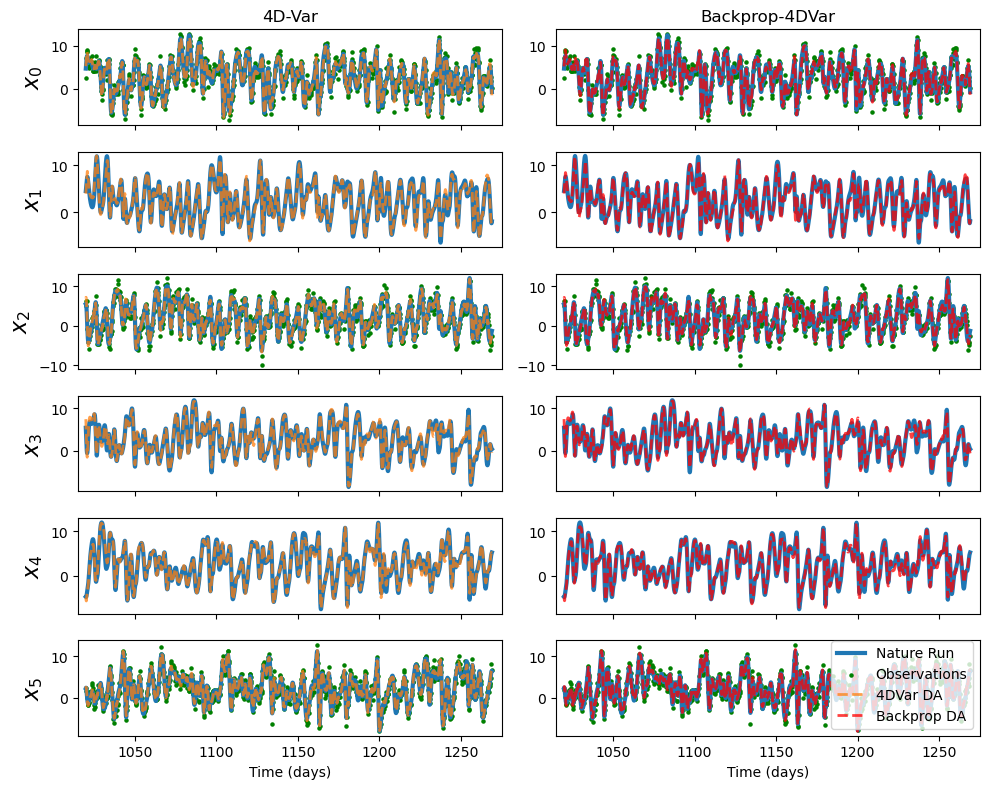

In [18]:
# Plot them all
fig, axes = plt.subplots(6, 2, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    if j ==0:
        ax[0].set_title('4D-Var')
        ax[1].set_title('Backprop-4DVar')

    for i in range(len(ax)):
        ax[i].set_xlim(1015, 1275)
        obj1 = ax[i].plot(nr_eval.times[:-20], nr_eval.values[:-20, j], label='Nature Run', lw=3)
        if j in obs_vec_l96.location_indices[0]:
            obj2 = ax[i].scatter(obs_vec_l96.times[:-4],
                       obs_vec_l96.values[:-4, np.where(j == obs_vec_l96.location_indices[0])[0]],
                       label='Observations',color='green', s=5)
    
    obj4 = ax[1].plot(nr_eval.times[:out_bp.values.shape[0]], out_bp.values[:, j],
            label='Backprop DA', ls='--', lw=2, color='red', alpha=0.75)
    obj3 = ax[0].plot(nr_eval.times[:out_4dvar.values.shape[0]], out_4dvar.values[:, j],
            label='4DVar DA', ls='--', lw=2, alpha=0.75)
    ax[0].set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j ==5:
        ax[1].legend(handles=[obj1[0], obj2, obj3[0], obj4[0]])
ax[0].set_xlabel('Time (days)')
ax[1].set_xlabel('Time (days)')
fig.tight_layout()


plt.show()

In [19]:
# Calc RMSE:
print(error_bp)


0.5374604894378573


In [20]:
print(error_4dvar)

0.5303952625600097


In [21]:
np.sqrt(np.mean(np.square(obs_vec_l96.errors)))

1.0227078397783662